In [58]:
!pip install "rtree>=0.8,<0.9"

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os

from tqdm.notebook import tqdm
from skimage.color import label2rgb
from glob import glob
%matplotlib inline

In [2]:
from labelme_utils import img_b64_to_arr
from annotations_utils import create_mask_from_points, get_random_string
from show_utils import show_image, subplot_images

## Labelme to data

In [434]:
# create directories
os.mkdir('./data/')
os.mkdir('./data/images/')
os.mkdir('./data/check_masks/')
os.mkdir('./data/pattern_masks')

annotation_paths = []
annotation_paths.extend(glob('./labelme_data/part2/*.json'))
annotation_paths.extend(glob('./labelme_data/part1/*.json'))
for annotation_path in tqdm(annotation_paths):
    with open(annotation_path) as F:
        annotation_data = json.loads(F.read())
    # convert labelme image format to np.array
    image = img_b64_to_arr(annotation_data['imageData'])
    # extract points
    check_points = [annotation['points'] for annotation in annotation_data['shapes']
                    if annotation['label'] == 'check']
    pattern_points = [annotation['points'] for annotation in annotation_data['shapes']
                      if annotation['label'] == 'pattern']
    # create image mask
    check_mask = create_mask_from_points(check_points, image.shape[:2]).clip(0, 1)
    pattern_mask = create_mask_from_points(pattern_points, image.shape[:2]).clip(0, 1)
    # save
    file_name = annotation_path.split('/')[-2] + '_' + annotation_path.split('/')[-1][:-5]
    cv2.imwrite('./data/images/' + file_name + '.jpg', image)
    cv2.imwrite('./data/check_masks/' + file_name + '.jpg', check_mask)
    cv2.imwrite('./data/pattern_masks/' + file_name + '.jpg', pattern_mask)

In [439]:
pattern_paths = glob('./data/pattern_masks/*')
for path in tqdm(pattern_paths):
    pattern_mask = cv2.imread(path, 2)
    gt_contours, hierarchy = cv2.findContours(pattern_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    gt_contours = sorted(gt_contours, key=lambda contour: cv2.contourArea(contour), reverse=True)
    contour_mask = create_mask_from_points(gt_contours[0:3], pattern_mask.shape[:2]).clip(0, 1)
    cv2.imwrite(path , contour_mask)

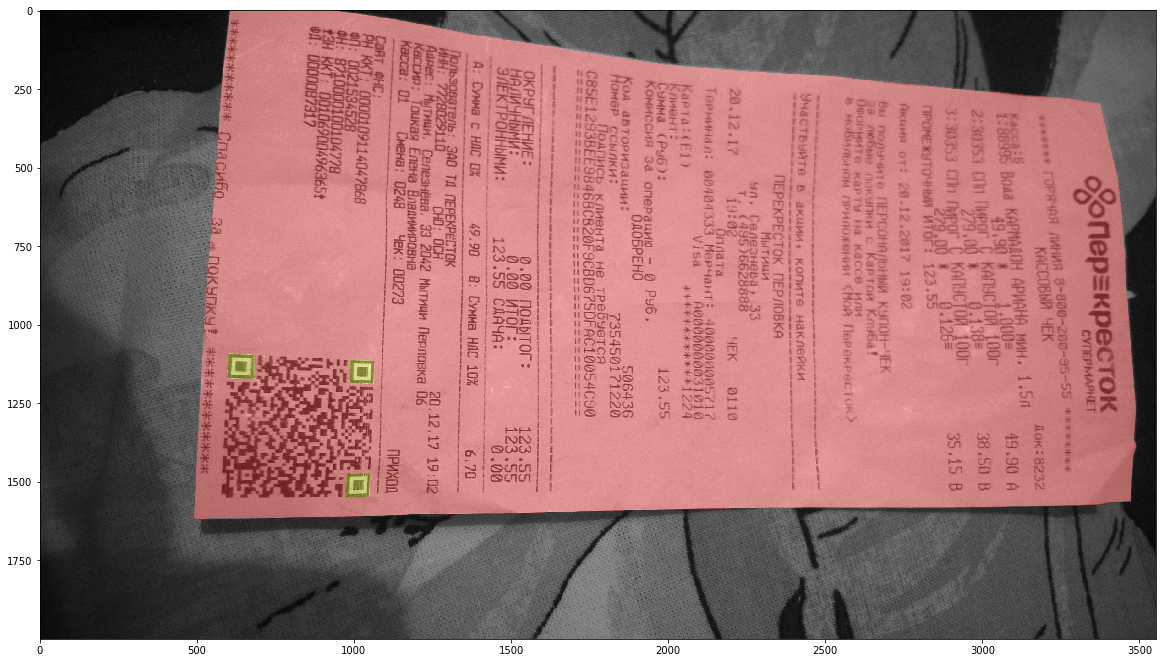

In [438]:
image = cv2.imread('./data/images/part2_0001.jpg')
check_mask = cv2.imread('./data/check_masks/part2_0001.jpg', 2)
pattern_mask = cv2.imread('./data/pattern_masks/part2_0001.jpg', 2)
show_image(label2rgb(check_mask + 2 * pattern_mask, image, bg_label=0))

### Train test split

In [69]:
from sklearn.model_selection import train_test_split

image_paths = sorted(glob('./data/images/*'))
mask_paths = sorted(glob('./data/pattern_masks/*'))
page_paths = sorted(glob('./data/check_masks/*'))

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_page_paths, test_page_paths = \
train_test_split(image_paths, mask_paths, page_paths, random_state=42, test_size=0.15)

train_image_paths, valid_image_paths, train_mask_paths, valid_mask_paths, train_page_paths, valid_page_paths = \
train_test_split(train_image_paths, train_mask_paths, train_page_paths, random_state=42, test_size=0.15)

print("train dataset size:", len(train_image_paths))
print("valid dataset size:", len(valid_image_paths))
print("test dataset size:", len(test_image_paths))

train dataset size: 67
valid dataset size: 12
test dataset size: 15


## Augmentations

In [34]:
import albumentations as albu
from albumentations.pytorch import ToTensor

def pre_transforms(image_size=640):
    return albu.Compose([
        albu.LongestMaxSize(image_size, cv2.INTER_LANCZOS4),
        albu.PadIfNeeded(image_size, image_size, border_mode=cv2.BORDER_CONSTANT)
    ])


def crop_transforms(size=640):
    result = albu.OneOf([albu.Compose(transforms=[albu.CropNonEmptyMaskIfExists(int(size/1.5), int(size/1.5), p=0.2),
                                       pre_transforms()]), 
           albu.Compose(transforms=[albu.CropNonEmptyMaskIfExists(int(size/1.5), size//2, p=0.2),
                                       pre_transforms()]),
           albu.Compose(transforms=[albu.CropNonEmptyMaskIfExists(size//2, int(size/1.5), p=0.2),
                                       pre_transforms()]),
           albu.Compose(transforms=[albu.CropNonEmptyMaskIfExists(size//2, size//2, p=0.2),
                                       pre_transforms()]),
          ], p=0.2)
    return result


def blur_transforms():
    result = [albu.Blur(p=0.1, blur_limit=7),
              albu.MedianBlur(p=0.1, blur_limit=5),
              albu.GaussianBlur(p=0.1, blur_limit=7),
              albu.MotionBlur(p=0.1, blur_limit=5),
              albu.Downscale(p=0.1, scale_min=0.5, scale_max=0.9, interpolation=cv2.INTER_LANCZOS4)]
    return result


def noise_transforms():
    result = [albu.GaussNoise(p=0.1, var_limit=(20, 80)),
              albu.JpegCompression(p=0.1, quality_lower=95),
              albu.IAAAdditiveGaussianNoise(p=0.05)]
    return result


def special_transforms():
    result = [
              albu.CLAHE(clip_limit=2, p=0.1),
              albu.IAASharpen(p=0.1),
              albu.IAAEmboss(p=0.1)
              ]
    return result


def rotate_transforms():
    result = [albu.RandomRotate90(p=0.1),
              albu.Rotate(20, p=0.2),
              albu.ShiftScaleRotate(shift_limit=0.1025, scale_limit=0.15, rotate_limit=45, p=0.1)]
    return result


def distortiot_transforms():
    result = [albu.GridDistortion(p=0.2),
              albu.IAAPiecewiseAffine(p=0.1),
              albu.OpticalDistortion(p=0.05, distort_limit=0.3, shift_limit=0.5),
              ]
    return result


def color_transforms():
    result = [albu.RandomBrightness(p=0.1),
              albu.RandomContrast(p=0.1),
              albu.RandomGamma(p=0.1),
              albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
              ]
    return result


def post_transforms():
    return [albu.Normalize(mean=0, std=1)]#, ToTensor()]


def compose(transforms_to_compose):
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result


hard_transforms = compose([crop_transforms(),
                           blur_transforms(),
                           noise_transforms(),
                           special_transforms(),
                           rotate_transforms(),
                           distortiot_transforms(),
                           color_transforms()
                          ])

train_transforms = compose([
    pre_transforms(),
    hard_transforms,
    post_transforms(),
])

valid_transforms = compose([pre_transforms(), post_transforms()])

In [35]:
def invers_transformation(mask, original_shape):
    """
    invert pad/resize transform

    :param mask: np.array: binary mask
    :param original_shape: (int, int): shape of original image
    :return: np.array: new mask
    """
    scale_shape = mask.shape
    scale = max(
        original_shape[0] / scale_shape[0], original_shape[1] / scale_shape[1]
    )
    central_crop_shape = (
        int(original_shape[0] / scale),
        int(original_shape[1] / scale),
    )
    center_crop_transfrom = albu.CenterCrop(
        central_crop_shape[0], central_crop_shape[1]
    )

    revers_mask = center_crop_transfrom(image=mask, mask=mask)["mask"]

    resize_transform = albu.Resize(original_shape[0], original_shape[1])
    target_mask = resize_transform(image=revers_mask, mask=revers_mask)["mask"]
    return target_mask

## Image Blending

In [36]:
background_paths = glob('/notebook/cv_share/Backgrounds/*')

In [37]:
from blending import double_laplac_blending, _get_random_point, extract_objects_by_mask, image2background
from image_utils import cut_rectangular_image_by_mask, rotate_image


def _get_image_shape(image_shape_limit, background_shape):
    a, b = image_shape_limit
    image_shape = (b - a) * np.random.random() + a
    image_shape = image_shape * min(background_shape[:2])
    return image_shape


def _image2background(background, image, mask, angle, image_shape, num_levels=1, point=None):
    image = rotate_image(image, angle)
    mask = rotate_image(mask, angle, borderValue=0)
    image, mask = cut_rectangular_image_by_mask(image, mask, True)
    aug_pre = albu.LongestMaxSize(image_shape, interpolation=cv2.INTER_LANCZOS4)
    aug = aug_pre(image=image, mask=mask)
    image = aug['image']
    mask = aug['mask']
    if point is None:
        point = _get_random_point(background, image)
    res_image, res_mask = double_laplac_blending(background, image, mask, point, num_levels)
    return res_image, res_mask, point


def _mask2background(background, general_mask, mask, point, angle, image_shape):
    general_mask = rotate_image(general_mask, angle, 0)
    mask = rotate_image(mask, angle, borderValue=0)
    general_mask, mask = cut_rectangular_image_by_mask(general_mask, mask, True)
    aug_pre = albu.LongestMaxSize(image_shape, interpolation=cv2.INTER_NEAREST)
    aug = aug_pre(image=general_mask, mask=mask)
    general_mask = aug['image']
    mask = aug['mask']
    res_general_mask, res_mask = image2background(background, general_mask, mask, point)
    return res_general_mask, res_mask


def images2background(background, image, mask, add_mask, image_shape_limit=(0.8, 0.95),
                      num_levels=1, rotate_limits=(-90, 90)):
        
    angle = np.random.randint(rotate_limits[0], rotate_limits[1])
    image_shape = _get_image_shape(image_shape_limit, background.shape)

    res_image, res_mask, point = _image2background(background, image, mask, num_levels=num_levels, 
                                                  angle=angle, image_shape=image_shape)
    res_add_mask, _ = _mask2background(np.zeros(background.shape[:2]).astype(np.uint8), add_mask, mask,
                                       image_shape=image_shape, point=point, angle=angle)
    return res_image, res_mask, res_add_mask

In [38]:
from torch.utils.data import Dataset

class CheckDataset(Dataset):
    """
    Dataset Factory
    """
    def __init__(self, image_paths, masks_paths, transforms=None, page_paths=None,
                 background_paths=None, check_limits=(1, 4), change_background_p=0.5, to_tensor=True):
        """
        :param image_paths: list of str: image paths
        :param masks_paths: list of str: mask paths
        :param transforms: function: augmentation
        :param page_paths: list of str: page mask paths
        :param background_paths: list of str: background paths(optional)
        :param check_limits: (int, int): min and max number of check in item
        :param change_background_p: float: probability of background replacement
        :param transforms: bool: return torch.Tensor or np.array
        :return: None
        """
        self.image_paths = image_paths
        self.masks_paths = masks_paths
        self.transforms = transforms
        self.to_tensor = to_tensor
        self.page_paths = page_paths
        self.background_paths = background_paths
        self.check_limits = check_limits
        self.change_background_p = change_background_p
        
    def __len__(self):
        """
        return: int: len
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        get item for torch DataLoader
        """
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.masks_paths[idx], 2).clip(0, 1) # ToDo remove clip
        assert np.max(mask) <= 1 and np.min(mask) >= 0, 'mask must be between 0 and 1!'
        
        if self.page_paths is not None and self.background_paths is not None and \
        np.random.binomial(n=1, p=self.change_background_p):
            background_path = np.random.choice(self.background_paths)
            background = cv2.imread(background_path)
            
            page_mask = cv2.imread(self.page_paths[idx], 2).clip(0, 1)
            image, new_page_mask = cut_rectangular_image_by_mask(image, page_mask, True)
            mask = cut_rectangular_image_by_mask(mask, page_mask, False)
            image, page_mask, mask = images2background(background, image, new_page_mask, mask)
        
        
        result = {"image": image, 'mask': mask}

        if self.transforms is not None:
            result = self.transforms(**result)
        if self.to_tensor:
            result['image'] = torch.tensor(np.transpose(result['image'], axes=(2, 0, 1))).type(torch.FloatTensor)
            result['mask'] = torch.tensor(result['mask'][None, :, :]).type(torch.FloatTensor)
        return result

In [39]:
train_dataset = CheckDataset(image_paths = train_image_paths,
                             masks_paths = train_mask_paths,
                             transforms = train_transforms,
                             page_paths=train_page_paths,
                             background_paths=background_paths, change_background_p=0.5);

valid_dataset = CheckDataset(image_paths = valid_image_paths,
                             masks_paths = valid_mask_paths,
                             transforms = valid_transforms);

show_dataset = CheckDataset(image_paths = train_image_paths,
                             masks_paths = train_mask_paths,
                             transforms = train_transforms,
                             page_paths=train_page_paths,
                             background_paths=background_paths, change_background_p=0.5, to_tensor=False);

In [40]:
images_to_show = []
for i in range(8):
    result = show_dataset[0]
    images_to_show.append(label2rgb(result['mask'], result['image'],bg_label=0))

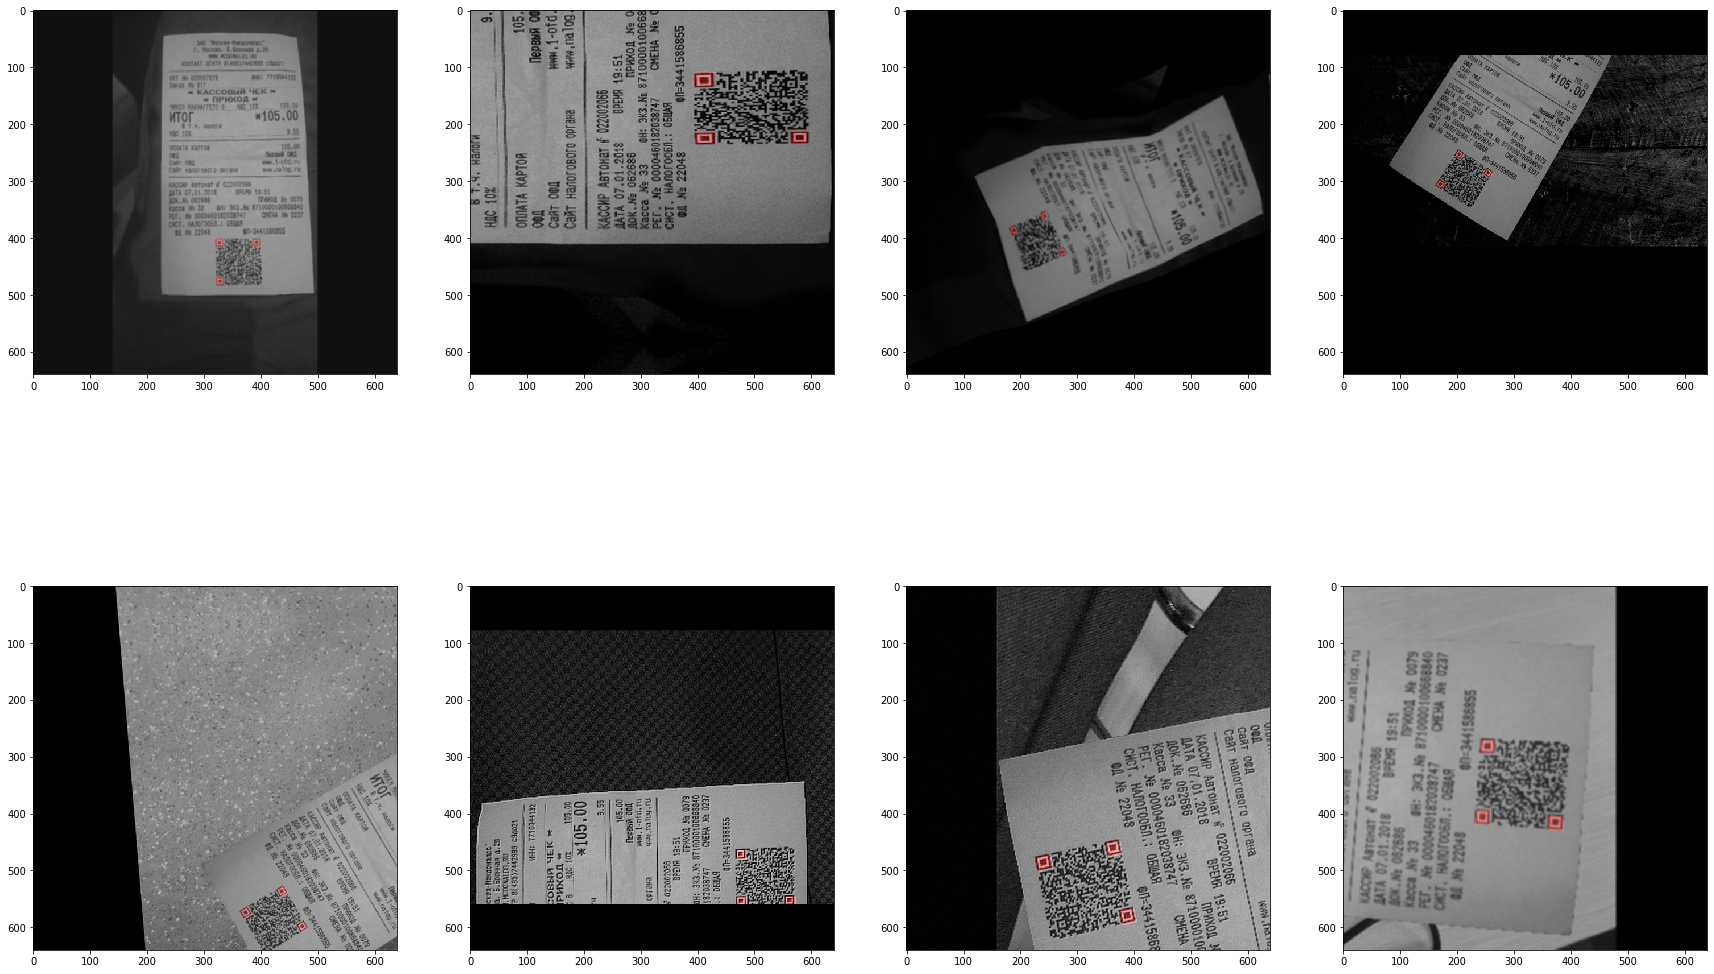

In [41]:
subplot_images(images_to_show, 3, 4, figsize=(30, 30))

In [42]:
import collections
from torch.utils.data import DataLoader

train_loader = DataLoader(
      train_dataset,
      batch_size=10, 
      shuffle=True,
      drop_last=True,
    )

valid_loader = DataLoader(
      valid_dataset,
      batch_size=10,
      shuffle=False,
      drop_last=True,
    )

loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = valid_loader

### Create model and Train it

In [43]:
import segmentation_models_pytorch as smp
import torch
import catalyst

from torch import nn
from catalyst.dl import utils as catalyst_utils

### Create model

In [44]:
encoder_name = 'mobilenet_v2'
encoder_weights = 'imagenet'
classes = 1
in_channels = 3
model = smp.FPN(encoder_name=encoder_name, 
                encoder_weights=encoder_weights,
                in_channels=in_channels,
                classes=classes)

In [46]:
from catalyst.contrib.nn import DiceLoss, IoULoss, FocalLossBinary

criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [47]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

model_params = catalyst_utils.process_model_params(model, layerwise_params=layerwise_params)

base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=10) # Note patience!

In [49]:
from catalyst.dl import SupervisedRunner

num_epochs = 300
logdir = "./logs/mobilenet_v2_2/"
device = catalyst_utils.get_device()
print(f"device: {device}")

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda


In [50]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, EarlyStoppingCallback

callbacks = [
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", 
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    EarlyStoppingCallback(patience=21, metric='iou', minimize=False) # Note patience!
]

### Train

In [99]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="iou",
    minimize_metric=False,
    verbose=True,
)

### Trace model

In [53]:
from catalyst.dl.utils import trace

In [52]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir)

!ls {logdir}/trace/

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2481: TracerWarning:

torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.



traced-forward.pth


In [56]:
model = trace.load_traced_model(
        f"{logdir}/trace/traced-forward.pth", 
        device="cpu")

### Evaluate model

In [63]:
from post_processing import MorphPostProcessing
from metrics import calculate_detection_metrics, get_detection_statistics
from shapely.geometry import Polygon

In [73]:
def make_prediction(image, model, PostProcessing, valid_transforms, threshold=0.5, output_format='mask'):
    model.eval();
    sigmoid = nn.Sigmoid()
    input_image = valid_transforms(image=image)['image']
    input_image = torch.tensor(np.transpose(input_image, axes=(2, 0, 1))).type(torch.FloatTensor)
    pred = model(input_image[None, :, :, :])
    pred = sigmoid(pred)[0, 0].detach().cpu().numpy()
    pred = (pred > threshold).astype(np.uint8)
    pred = PostProcessing.transform_mask(pred)
    pred = invers_transformation(pred, image.shape[:2])
    if output_format == 'contours':
        pred = PostProcessing.get_contours(pred)
    if output_format == 'boxes':
        pred = PostProcessing.get_boxes(pred)
    return pred

In [65]:
def min_suppression_contour_filter(contours, mask, ratio=4):
    areas = [cv2.contourArea(contour) for contour in contours]
    max_area = max(areas)
    permissible_area = max_area / ratio
    permissible_contours = list(filter(lambda contour: cv2.contourArea(contour) >= permissible_area,  contours))
    return permissible_contours

In [92]:
PostProcessing = MorphPostProcessing(kernel_size=3, opening_it=1, erosion_it=1, dilation_it=1,
                                     contour_filter=min_suppression_contour_filter)
GTPostProcessing = MorphPostProcessing(0, 0, 0, 0)

image_path = test_image_paths[3]
mask_path = test_mask_paths[3]

image = cv2.imread(image_path)
gt_mask = cv2.imread(mask_path, 2)
gt_boxes = GTPostProcessing.get_boxes(gt_mask)
pred_mask = make_prediction(image, model, PostProcessing, valid_transforms, 0.5, 'mask')

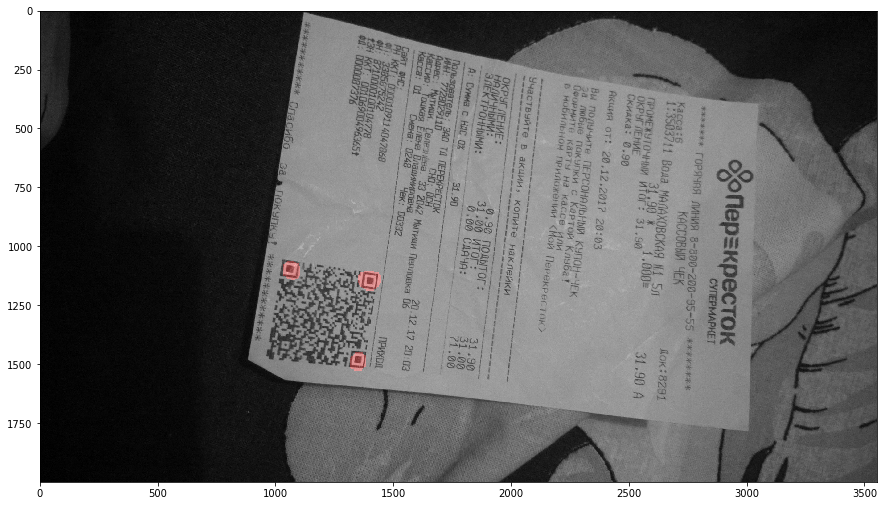

In [93]:
show_image(label2rgb(pred_mask, image, bg_label=0), figsize=(15, 15))

In [107]:
result = {'true_positive': 0,
          'false_positive': 0,
          'false_negative': 0}
for image_path, mask_path in tqdm(zip(test_image_paths, test_mask_paths), total=len(test_image_paths)):
    image = cv2.imread(image_path)
    gt_mask = cv2.imread(mask_path, 2)
    gt_contours = GTPostProcessing.get_contours(gt_mask)
    assert len(gt_contours) == 3
    pred_contours = make_prediction(image, model, PostProcessing, valid_transforms, 0.5, 'contours')
    statistics = get_detection_statistics(pred_contours, gt_contours, 0.5, check_input=True,
                                          input_type='contour')
    result['true_positive'] += statistics['true_positive']
    result['false_positive'] += statistics['false_positive']
    result['false_negative'] += statistics['false_negative']

final_metrics = calculate_detection_metrics(**result)

In [108]:
print('Test')
print('precision:', final_metrics['precision'])
print('recall:', final_metrics['recall'])
print('f_score:', final_metrics['f_score'])

Test
precision: 1.0
recall: 0.9777777777777777
f_score: 0.9887640448938264


__Conclusion__:

For simple patterns detection on a check, it is enough to use a simple segmentation model (only 2M parameters). It is easy to see from the examples, the masks turned out to be somewhat rude.
The model can be improved by simply increasing the input resolution or by complicating the model.